# **Banking Client Segmentation using K-Medoids**

This notebook implements a **complete clustering pipeline** for **banking clients segmentation** using the **K-Medoids algorithm**.

## **Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed data types)
3. **Apply K-Medoids Clustering**
4. **Evaluate Clustering Performance**
5. **Visualize Results using t-SNE**
6. **Interpret the Clusters** (Understanding the characteristics of each group)


In [19]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])

# Display first 5 rows
data.head()


,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


In [20]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
import numpy as np

# Define categorical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']

# Separate numerical & categorical features
numerical_features = data.drop(columns=categorical_columns)
categorical_features = data[categorical_columns]

# Scale numerical features
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(numerical_features)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(categorical_features)

# Get feature names from OneHotEncoder
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

# Concatenate processed features
X_preprocessed = np.concatenate((X_num_scaled, X_cat_encoded), axis=1)

# Convert to DataFrame for readability
all_feature_names = numerical_features.columns.tolist() + encoded_feature_names.tolist()
X_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# Display first 5 rows
print(f'Processed Data Shape: {X_preprocessed.shape}')
print("\nFirst 5 rows of processed data:")
print(X_df.head())

Processed Data Shape: (5000, 28)

First 5 rows of processed data:
        Age  FamilySize    Income    Wealth      Debt    FinEdu       ESG  \
0  0.065789         0.6  0.679599  0.705895  0.268264  0.770735  0.465122   
1  0.368421         0.0  0.873299  0.919090  0.747693  0.892883  0.521675   
2  0.250000         0.2  0.942846  0.902289  0.451701  0.504873  0.640388   
3  0.631579         0.4  0.548115  0.425051  0.614591  0.512343  0.518146   
4  0.184211         0.0  0.820609  0.734639  0.851100  0.889625  0.783674   

    Digital  BankFriend  LifeStyle  ...  Job_5  Area_1  Area_2  Area_3  \
0  0.718914    0.581720   0.612604  ...    0.0     0.0     1.0     0.0   
1  0.986877    0.778748   0.868977  ...    0.0     0.0     1.0     0.0   
2  0.772055    0.677446   0.761279  ...    0.0     1.0     0.0     0.0   
3  0.607305    0.648808   0.337033  ...    0.0     1.0     0.0     0.0   
4  0.730646    0.746853   0.915946  ...    0.0     1.0     0.0     0.0   

   CitySize_1  CitySize_2 

In [21]:
import gower

# Compute Gower Distance Matrix
gower_distances = gower.gower_matrix(X_preprocessed)

# Display first 5 rows
gower_distances[:5, :5]


array([[0.        , 0.3308228 , 0.3688255 , 0.3962298 , 0.46500587],
       [0.3308228 , 0.        , 0.28962833, 0.4133628 , 0.27291024],
       [0.3688255 , 0.28962833, 0.        , 0.17167616, 0.21496232],
       [0.3962298 , 0.4133628 , 0.17167616, 0.        , 0.18863821],
       [0.46500587, 0.27291024, 0.21496232, 0.18863821, 0.        ]],
      dtype=float32)

In [22]:
from sklearn_extra.cluster import KMedoids

# Define number of clusters
k_values = [3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results
cluster_results = {}

for k in k_values:
    print(f'Clustering with k={k}...')
    
    # Run K-Medoids
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42, init='k-medoids++', max_iter=300)
    labels = kmedoids.fit_predict(gower_distances)
    
    # Store results
    cluster_results[k] = labels

print("✅ Clustering Completed")


Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...
✅ Clustering Completed


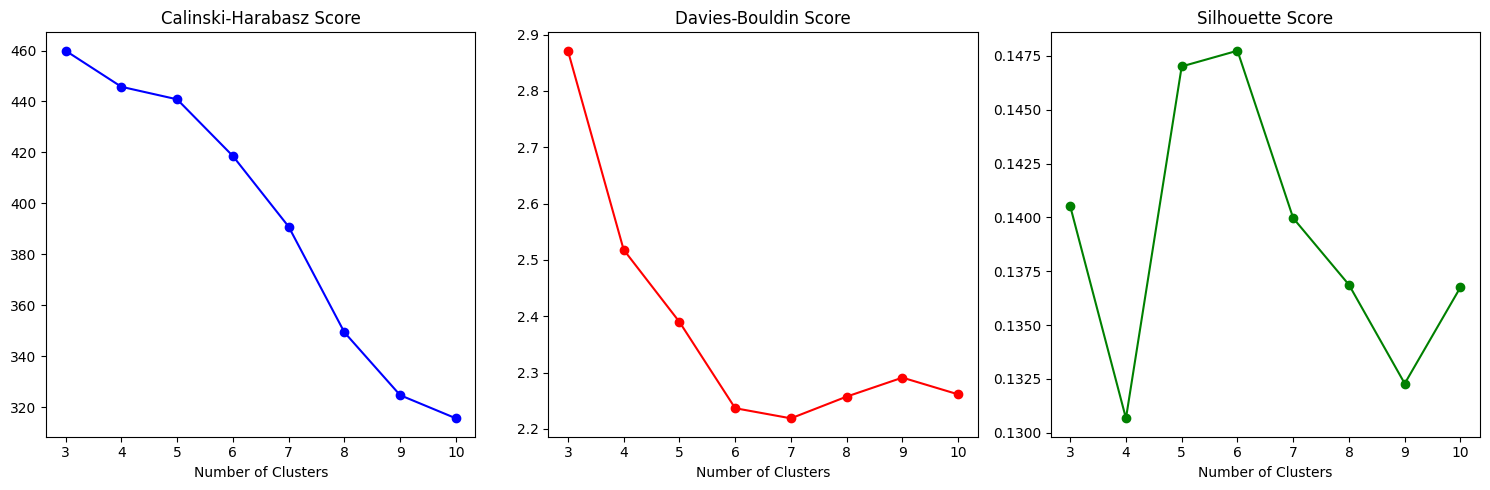

✅ Optimal k (CH): 3
✅ Optimal k (DB): 7
✅ Optimal k (Silhouette): 6


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# Evaluate clustering
def evaluate_clustering(X, cluster_results, gower_distances=None):
    if not cluster_results:
        print("⚠️ No clustering results provided. Exiting evaluation.")
        return None, None, None

    k_values = list(cluster_results.keys())

    ch_scores, db_scores, sil_scores = [], [], []

    for k in k_values:
        labels = cluster_results[k]

        try:
            ch_scores.append(calinski_harabasz_score(X, labels))
            db_scores.append(davies_bouldin_score(X, labels))
            sil_scores.append(silhouette_score(gower_distances, labels, metric='precomputed'))
        except ValueError as e:
            print(f"⚠️ Skipping k={k} due to an error: {e}")
            ch_scores.append(np.nan)
            db_scores.append(np.nan)
            sil_scores.append(np.nan)

    # Plot metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.plot(k_values, ch_scores, 'bo-')
    ax1.set_title('Calinski-Harabasz Score')
    ax1.set_xlabel('Number of Clusters')

    ax2.plot(k_values, db_scores, 'ro-')
    ax2.set_title('Davies-Bouldin Score')
    ax2.set_xlabel('Number of Clusters')

    ax3.plot(k_values, sil_scores, 'go-')
    ax3.set_title('Silhouette Score')
    ax3.set_xlabel('Number of Clusters')

    plt.tight_layout()
    plt.show()

    print(f"✅ Optimal k (CH): {k_values[np.argmax(ch_scores)]}")
    print(f"✅ Optimal k (DB): {k_values[np.argmin(db_scores)]}")
    print(f"✅ Optimal k (Silhouette): {k_values[np.argmax(sil_scores)]}")

    return ch_scores, db_scores, sil_scores

# Evaluate clustering
ch_scores, db_scores, sil_scores = evaluate_clustering(X_preprocessed, cluster_results, gower_distances)


In [40]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Check if Gower distance matrix is valid
if np.isnan(gower_distances).any() or np.isinf(gower_distances).any():
    raise ValueError("⚠️ Gower distance matrix contains NaN or Inf values. Check your preprocessing!")

if gower_distances.shape[0] != gower_distances.shape[1]:
    raise ValueError("⚠️ Gower distance matrix must be square (NxN).")

# Compute 3D t-SNE projection (Fixing the init='pca' issue)
tsne = TSNE(n_components=3, metric='precomputed', init='random', random_state=42)
X_tsne_3d = tsne.fit_transform(gower_distances)

# Assign best k from evaluation (Make sure best_k exists in cluster_results)
best_k = 7
if best_k not in cluster_results:
    raise ValueError(f"⚠️ best_k={best_k} is not in cluster_results. Check clustering output!")

labels = cluster_results[best_k]

# Create DataFrame for visualization
df_plot = pd.DataFrame({'x': X_tsne_3d[:, 0], 'y': X_tsne_3d[:, 1], 'z': X_tsne_3d[:, 2], 'Cluster': labels})

# Explicitly set a reduced point size
point_size = 5  # Adjust this value to control marker size

# Generate interactive 3D scatter plot using go.Scatter3d for explicit control over marker size
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=df_plot['x'],
    y=df_plot['y'],
    z=df_plot['z'],
    mode='markers',
    marker=dict(
        size=point_size,  # Explicitly setting the size
        color=df_plot['Cluster'],  # Color by cluster
        colorscale='Turbo',  # Set color scale
        opacity=0.7  # Adjust transparency
    )
))

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization (k={best_k})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=800,  # Adjusted figure width
    height=800   # Adjusted figure height
)

fig.show()

In [25]:
import pandas as pd
from IPython.display import display
import numpy as np

# Restore feature names for numerical and categorical variables
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
all_feature_names = numerical_features.columns.tolist() + encoded_feature_names.tolist()

# Convert back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Reverse MinMax scaling to restore original numerical values
summary_original_scale = summary.copy()
summary_original_scale[numerical_features.columns] = scaler.inverse_transform(summary[numerical_features.columns])

# Convert one-hot encoded categorical values back to original labels
for i, cat_col in enumerate(categorical_columns):
    # Identify the one-hot encoded column names for this categorical feature
    one_hot_columns = [col for col in summary_original_scale.columns if col.startswith(cat_col + "_")]

    # Get the most likely category per cluster using argmax
    summary_original_scale[cat_col] = summary_original_scale[one_hot_columns].idxmax(axis=1)

    # Convert from "Category_X" to just "X"
    summary_original_scale[cat_col] = summary_original_scale[cat_col].str.split('_').str[1]

    # Drop the one-hot encoded columns
    summary_original_scale = summary_original_scale.drop(columns=one_hot_columns)

# Display the DataFrame as a readable table
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)  # Using Jupyter's display() for better formatting

🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):


,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Gender,Job,Area,CitySize,Investments
Cluster,,,,,,,,,,,,,,,,,
0,54.004684,2.382904,0.661092,0.652659,0.506280,0.594475,0.618081,0.617446,0.640366,0.554337,0.571719,0.568142,1,2,1,2,3
1,68.330132,2.759904,0.518051,0.536872,0.388659,0.448740,0.551638,0.440798,0.579407,0.394030,0.359418,0.518379,1,2,1,1,1
2,78.335694,2.041076,0.396690,0.401939,0.151855,0.349365,0.612343,0.312001,0.626071,0.264116,0.265527,0.330718,1,5,1,2,2
3,53.647919,2.835771,0.564921,0.537524,0.491843,0.483006,0.541776,0.507648,0.570693,0.419052,0.445574,0.542173,0,2,1,1,3
4,52.639155,2.124760,0.767545,0.779449,0.557734,0.685165,0.645021,0.735073,0.742945,0.661342,0.720702,0.585180,0,2,1,3,2
5,65.946479,2.960563,0.537845,0.570094,0.427727,0.483934,0.532385,0.507484,0.589115,0.429929,0.436229,0.531518,0,2,1,2,2
6,45.108830,1.924025,0.655125,0.655169,0.518422,0.609818,0.658683,0.674434,0.638861,0.619226,0.654065,0.597242,1,2,1,3,2
